In [ ]:
%%capture
import os
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/COLAB/TCR_projects"
os.chdir(path)


**TCR-epitope binding affinity prediction**

**Data:** The notebook uses the MixTCRpred dataset and focuses on a "Leave One Epitope Out" cross-validation strategy. This means that for each epitope, both the epitope and its associated TCR sequences are unseen during the model's training phase.

**Input Features:**  
* **Epitope and TCR Embeddings:** Generated using either the 'esm3-small-2024-08' or 'esm2_t6_8M_UR50D' ESM models.
* **TCR VJ genes:** Encoded as categorical variables.
* **HLA and species information:** Encoded as categorical variables for the epitope.

**Negative Sampling:** Artificial negative samples (non-binding TCR-epitope pairs) are created using a random shuffling strategy to balance the dataset. Computationally generated negative / positive ratio set at 5. Max positive cases in test set is set at 1000, since there might not be enough TCR sequences for a ratio of 5.

**Machine Learning Models:** finetuning is done using:
    * Logistic Regression
    * Random Forest
    * Multi-layer Perceptron (MLP)

**Evaluation:** Model performance is assessed using the Area Under the ROC Curve (AUC) metric, computed for each epitope individually.


In [ ]:

import random
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

############################## Negative sampling: random shuffling ##############################

#The random shuffling strategy, also known as "Random TCR" or "Random Epitope" depending on which element is shuffled, involves creating artificial negative samples by randomly pairing TCRs with epitopes that are not their known binding partners.
#Separation of Data: First, the positive TCR-epitope pairs are split into training and test sets.
#Random Pairing: Within each set (train and test), TCRs or epitopes are randomly shuffled to create new pairs that are assumed to be non-binding.
#Negative Sample Generation: These new random pairs are labeled as negative samples.

# write a script to pair TCRs and epitopes, excluding their true binding partners for mat_train_tab
# mat_train_tab has columns epitope_aa, tcr_full and value. Value of 1 mean binding, value of 0 means non binding.

def generate_negative_samples(df,tcr_features,num_epitopes=100, num_tcrs=10):
    # generate negatives for both epitope and TCRs
    negative_samples = []

    # Ensure the number of samples does not exceed the number of unique elements
    unique_epitopes = list(df['epitope'].unique())
    unique_tcrs = list(df[tcr_features].unique())

    sampled_epitopes = random.sample(unique_epitopes, min(num_epitopes, len(unique_epitopes)))
    sampled_tcrs = random.sample(unique_tcrs, min(num_tcrs, len(unique_tcrs)))

    for epitope in sampled_epitopes:
        for tcr in sampled_tcrs:
            if df[(df['epitope'] == epitope) & (df[tcr_features] == tcr)].empty:
                negative_samples.append({'epitope': epitope, tcr_features: tcr, 'value': 0})

    return pd.DataFrame(negative_samples)

def generate_negative_samples_epitope(df,tcr_features, epitope, num_tcrs=10):
  # generate negatives for TCRs only.
  negative_samples = []

  # Ensure the number of samples does not exceed the number of unique elements
  unique_epitopes = epitope
  unique_tcrs = list(df[tcr_features].unique())

  #sampled_epitopes = random.sample(unique_epitopes, min(num_epitopes, len(unique_epitopes)))
  sampled_tcrs = random.sample(unique_tcrs, min(num_tcrs, len(unique_tcrs)))

  #for epitope in sampled_epitopes:
  for tcr in sampled_tcrs:
      if df[(df['epitope'] == epitope) & (df[tcr_features] == tcr)].empty:
          negative_samples.append({'epitope': epitope, tcr_features: tcr, 'value': 0})

  return pd.DataFrame(negative_samples)

def preprocess_features(feat, res, train_indices, test_indices):
    x_train = feat.iloc[train_indices, :]
    y_train = res[train_indices]
    x_test = feat.iloc[test_indices, :]
    y_test = res[test_indices]
    # scale the data
    scaler = StandardScaler().fit(x_train)
    x_train = pd.DataFrame(scaler.transform(x_train), index=x_train.index, columns=x_train.columns)
    x_test = pd.DataFrame(scaler.transform(x_test), index=x_test.index, columns=x_test.columns)
    return x_train, y_train, x_test, y_test

def train (algo, x_train, y_train, x_test):
  model = None
  if algo == "sklearn_mlp":
      model = MLPClassifier(
          hidden_layer_sizes=(100, 50, 10), activation='relu',
          learning_rate_init=0.001, alpha=0.01, max_iter=10,
          early_stopping=False, validation_fraction=0.1
      )
  elif algo == "sklearn_randomforest":
      model = RandomForestClassifier(
          n_estimators=1000, max_depth=10, oob_score=True
      )
  elif algo == "sklearn_logit":
      model = LogisticRegression(
          C=0.5, solver="saga", penalty="elasticnet",
          l1_ratio=0.5, class_weight="balanced"
      )

  if model:
      model.fit(x_train, y_train)
      x_train_proba = model.predict_proba(x_train)[:, 1]
      x_test_proba = model.predict_proba(x_test)[:, 1]
      return x_train_proba, x_test_proba, model
  else:
      raise ValueError("Specified algorithm is not supported")


def get_feature_importance(model, algo):
  # get model weights for each algorithm
  temp = []
  if algo == "sklearn_logit":
      temp = model.coef_
  if algo == "sklearn_randomforest":
      temp = model.feature_importances_
  if len(temp) == 1:
      temp = temp.transpose()
  return temp

def aggregate_feature_importance(imp, f_name):
  # aggregate by feature and iteration
  imp_agg = imp.groupby(['feature', 'iteration'])['importance'].mean().reset_index()
  # aggregate by feature and compute mean and sd across all iterations for each feature
  imp_agg = imp_agg.groupby('feature').agg({'importance': ['mean', 'std']})
  imp_agg.columns = ['importance', 'std']
  imp_agg.reset_index(inplace=True)
  imp_agg.columns = ['feature_name', 'importance', 'std']
  return imp_agg


########################################## run ML ###########################################

def run_ML(epitope,epitope_embeddings,tcr_embeddings):
  print(epitope)

  run_ite = 0  # Initialize iteration number of each repetition, outer loop
  probability_all = pd.DataFrame()
  importance_all  = pd.DataFrame()
  for rep in range(repetition):
    run_ite += 1

    # split the dataset
    mat_train = mat.drop(epitope, axis=1)
    mat_train_tab = mat_train.stack().reset_index().rename(columns={0:'value'})

    mat_test = pd.DataFrame(mat[epitope])
    mat_test_tab = mat_test.stack().reset_index().rename(columns={0:'value'})
    mat_test_tab.columns = mat_train_tab.columns

    ############################## Negative sampling: random shuffling ##############################

    # pos / neg ratio
    mat_train_pos = len(mat_train_tab)
    epitope_number = len(np.unique(mat_train_tab["epitope"]))
    negative_df = generate_negative_samples(mat_train_tab, tcr_features=tcr_features,
                  num_epitopes=epitope_number, num_tcrs=ratio*round(mat_train_pos/epitope_number))
    mat_train_tab = pd.concat([mat_train_tab[negative_df.columns], negative_df], ignore_index=True)


    max_pos_cases = 1000 # max positive cases for test set
    mat_test_tab = mat_test_tab.sample(n=min(max_pos_cases, len(mat_test_tab)))
    mat_test_pos = np.min([max_pos_cases, len(mat_test_tab)])

    # LOOCV, so TCRs have to be taken from training set
    negative_df = generate_negative_samples_epitope(mat_train_tab, tcr_features, epitope=epitope, num_tcrs = ratio*mat_test_pos )
    mat_test_tab = pd.concat([mat_test_tab[negative_df.columns], negative_df], ignore_index=True)
    # remove the TCRs of the test set from the training set
    mat_train_tab = mat_train_tab.loc[~mat_train_tab[tcr_features].isin(mat_test_tab[tcr_features]), :]

    print(mat_train_tab.value.value_counts() )
    print(mat_test_tab.value.value_counts() )


    def get_embeddings(row):
      epitope = epitope_embeddings.loc[row['epitope']].values
      tcr = tcr_embeddings.loc[row[tcr_features]].values
      return np.concatenate((epitope, tcr))

    ################# training set features
    features_train = mat_train_tab.apply(get_embeddings, axis=1)
    features_train = pd.DataFrame(features_train.tolist(), index=features_train.index)
    features_train.index = mat_train_tab["epitope"] + "_" + mat_train_tab[tcr_features]
    features_train.columns = epitope_embeddings.columns.tolist() + tcr_embeddings.columns.tolist()
    ## add other information
    df_encoded_TCR_subset = df_encoded_TCR.loc[mat_train_tab[tcr_features], : ]
    df_encoded_epitope_subset = df_encoded_epitope.loc[mat_train_tab["epitope"], : ]

    ## combine
    # "ESM + VJ genes" "all features" "ESMonly" "withoutESM"
    if features_name == "ESM + VJ genes":
      features_train_all = pd.concat([features_train.reset_index(drop=True), df_encoded_TCR_subset.reset_index(drop=True)], axis=1)
    if features_name == "all features":
      features_train_all = pd.concat([features_train.reset_index(drop=True), df_encoded_TCR_subset.reset_index(drop=True), df_encoded_epitope_subset.reset_index(drop=True)], axis=1)
    if features_name == "ESMonly":
      features_train_all = features_train
    if features_name == "withoutESM":
      features_train_all = pd.concat([df_encoded_TCR_subset.reset_index(drop=True), df_encoded_epitope_subset.reset_index(drop=True)], axis=1)

    features_train_all.index = features_train.index

    ################# test set features
    features_test = mat_test_tab.apply(get_embeddings, axis=1)
    features_test = pd.DataFrame(features_test.tolist(), index=features_test.index)
    features_test.index = mat_test_tab["epitope"] + "_" + mat_test_tab[tcr_features]
    features_test.columns = epitope_embeddings.columns.tolist() + tcr_embeddings.columns.tolist()
    ## add other information
    df_encoded_TCR_subset = df_encoded_TCR.loc[mat_test_tab[tcr_features], : ]
    df_encoded_epitope_subset = df_encoded_epitope.loc[mat_test_tab["epitope"], : ]

    ## combine
    # "ESM + VJ genes" "all features" "ESMonly" "withoutESM"
    if features_name == "ESM + VJ genes":
      features_test_all = pd.concat([features_test.reset_index(drop=True), df_encoded_TCR_subset.reset_index(drop=True)], axis=1)
    if features_name == "all features":
      features_test_all = pd.concat([features_test.reset_index(drop=True), df_encoded_TCR_subset.reset_index(drop=True), df_encoded_epitope_subset.reset_index(drop=True)], axis=1)
    if features_name == "ESMonly":
      features_test_all = features_test
    if features_name == "withoutESM":
      features_test_all = pd.concat([df_encoded_TCR_subset.reset_index(drop=True), df_encoded_epitope_subset.reset_index(drop=True)], axis=1)

    features_test_all.index = features_test.index

    RES_train = mat_train_tab.value.tolist()
    RES_test = mat_test_tab.value.tolist()

    ############################################ run ML ############################################
    X_train = features_train_all
    X_test  = features_test_all
    y_train = RES_train
    y_test  = RES_test

    X_train.columns = X_train.columns.astype(str)
    X_test.columns  = X_test.columns.astype(str)

    train_prob, test_prob, model = train (algorithm, X_train, y_train, X_test)

    p_test = pd.DataFrame(
        { 'split': "test",
          'epitope': epitope,
          'iteration': [run_ite] * len(y_test),
          'sample': X_test.index,
          'predicted_prob': test_prob,
          'RealClass': y_test
          }
    )

    p_train = pd.DataFrame(
        { 'split': "train",
          'epitope': epitope,
          'iteration': [run_ite] * len(y_train),
          'sample': X_train.index,
          'predicted_prob': train_prob,
          'RealClass': y_train
          }
    )

    p = pd.concat([p_test, p_train], ignore_index=True)
    probability_all = pd.concat([probability_all, p], ignore_index=True)


    # Get feature importance from the model
    importance_values = get_feature_importance(model=model, algo=algorithm)
    importance = pd.DataFrame({
        'iteration': [run_ite] * len(importance_values),
        'feature': X_train.columns,
        'importance': importance_values.flatten()
    })

    # append to the importance_all list
    importance_all = pd.concat([importance_all, importance], ignore_index=True)

    return probability_all, importance_all



from sklearn.metrics import roc_curve, auc
from numpy import interp

import seaborn as sns
import matplotlib.pyplot as plt

def plot_ROC_curve(probability):
  aucs_all = []
  mean_fpr = np.linspace(0, 1, 100)
  for i in range(1, len(probability["iteration"].unique()) + 1):
    pred_run = probability[probability["iteration"] == i]
    epitopes = np.unique( [i.split('_', 1)[0] for i in pred_run["sample"]] )

    # plot an average ROC curve across all runs. Values are interpolated.
    tprs = []
    aucs = []
    for epitope in epitopes:

      # select epitope
      pred_run = probability[probability["iteration"] == i]
      pred_run = pred_run[pred_run['sample'].str.contains(epitope)]

      fpr, tpr, thresh = roc_curve(pred_run["RealClass"], pred_run["predicted_prob"])
      interpolated_tpr = interp(mean_fpr, fpr, tpr)
      interpolated_tpr[0] = 0.0
      roc_auc = auc(fpr, tpr)
      tprs.append(interpolated_tpr)
      aucs = pd.DataFrame([epitope, roc_auc]).transpose()

      if len(aucs_all)== 0:
        aucs_all = aucs
      else:
        aucs_all = pd.concat([aucs_all, aucs])

  aucs_all.columns = ["epitope","AUC"]
  aucs_all = aucs_all.groupby('epitope').agg('mean')

  auc_values = aucs_all.AUC
  print(auc_values)


  # Assuming 'auc_values' is a pandas Series
  plt.figure(figsize=(3, 5))
  sns.boxplot(y=auc_values, color='lightblue', width=0.4) # Adjust width here
  sns.swarmplot(y=auc_values, color='darkred', size=6) # Adjust size here
  plt.xlabel('AUC')
  plt.title('AUC Scores')
  plt.ylim(0, 1)  # Set y-axis limits to 0-1
  # save to pdf
  os.makedirs("fig", exist_ok=True)
  plt.savefig("fig/auc_values_epitope_boxplot_"+features_name+"_"+algorithm+"_N_TCRs"+str(N_TCRs)+"_"+split+"_species_"+species+"_MHC_"+MHC_class+".pdf", format='pdf', bbox_inches='tight')
  plt.show()

  print(f"Mean AUC: {np.mean(auc_values)}")
  print(f"Median AUC: {np.median(auc_values)}")

  return auc_values


In [ ]:
################################# TCR-Epitope Binding Affinity Prediction Task #################################
os.chdir(path)
combined_df = pd.read_csv("MixTCRpred/full_training_set_146pmhc.csv")

# combine cdr3
combined_df["cdr3"] = combined_df["cdr3_TRA"] + combined_df["cdr3_TRB"]
combined_df["value"] = 1
combined_df.index = combined_df["epitope"] + "_" + combined_df["cdr3"]
combined_df

############################################ choose ESM model ############################################

# "esm3-small-2024-08" "esm2_t6_8M_UR50D"
model_name = "esm2_t6_8M_UR50D"
epitope_embeddings = pd.read_csv('MixTCRpred/data/epitope_embeddings_'+model_name+'.csv',index_col=0)
cdr3_embeddings = pd.read_csv('MixTCRpred/data/cdr3_embeddings_'+model_name+'.csv',index_col=0)

epitope_embeddings.columns = "epitope_" + epitope_embeddings.columns
cdr3_embeddings.columns    = "cdr3_" + cdr3_embeddings.columns

############################## subset of available embeddings ##############################
combined_df = combined_df.loc[combined_df["epitope"].isin(epitope_embeddings.index) , :]
combined_df = combined_df.loc[combined_df["cdr3"].isin(cdr3_embeddings.index) , :]
combined_df

,epitope,cdr3_TRA,cdr3_TRB,TRAV,TRAJ,TRBV,TRBJ,MHC,MHC_class,species,cdr3,value
DIYKGVYQFKSV_CAGGADRLTFCASSPAGNTLYF,DIYKGVYQFKSV,CAGGADRLTF,CASSPAGNTLYF,TRAV14-3,TRAJ45,TRBV14,TRBJ1-3,H2-IAb,MHCII,MusMusculus,CAGGADRLTFCASSPAGNTLYF,1
DIYKGVYQFKSV_CAASGGSNYNVLYFCAWSLWGGPSAETLYF,DIYKGVYQFKSV,CAASGGSNYNVLYF,CAWSLWGGPSAETLYF,TRAV14N-3,TRAJ21,TRBV31,TRBJ2-3,H2-IAb,MHCII,MusMusculus,CAASGGSNYNVLYFCAWSLWGGPSAETLYF,1
DIYKGVYQFKSV_CAASYNYAQGLTFCASRDWGGRQDTQYF,DIYKGVYQFKSV,CAASYNYAQGLTF,CASRDWGGRQDTQYF,TRAV14N-3,TRAJ26,TRBV13-3,TRBJ2-5,H2-IAb,MHCII,MusMusculus,CAASYNYAQGLTFCASRDWGGRQDTQYF,1
DIYKGVYQFKSV_CAAQTGNYKYVFCASGDAGTGQDTQYF,DIYKGVYQFKSV,CAAQTGNYKYVF,CASGDAGTGQDTQYF,TRAV14D-3-DV8,TRAJ40,TRBV12-2+TRBV13-2,TRBJ2-5,H2-IAb,MHCII,MusMusculus,CAAQTGNYKYVFCASGDAGTGQDTQYF,1
DIYKGVYQFKSV_CAASLTGGYKVVFCAWRTDNQDTQYF,DIYKGVYQFKSV,CAASLTGGYKVVF,CAWRTDNQDTQYF,TRAV14N-3,TRAJ12,TRBV31,TRBJ2-5,H2-IAb,MHCII,MusMusculus,CAASLTGGYKVVFCAWRTDNQDTQYF,1
...,...,...,...,...,...,...,...,...,...,...,...,...
GMGPLLATV_CAVLNNARLMFCASSVDRVADTQYF,GMGPLLATV,CAVLNNARLMF,CASSVDRVADTQYF,TRAV12-2,NaN,TRBV27,NaN,HLA-A*02:01,MHCI,HomoSapiens,CAVLNNARLMFCASSVDRVADTQYF,1
GMGPLLATV_CATDNDMRFCASSFGPDEQYF,GMGPLLATV,CATDNDMRF,CASSFGPDEQYF,NaN,NaN,TRBV13,NaN,HLA-A*02:01,MHCI,HomoSapiens,CATDNDMRFCASSFGPDEQYF,1
GMGPLLATV_CAYRSFNNNDMRFCASRSRGGHSPLHF,GMGPLLATV,CAYRSFNNNDMRF,CASRSRGGHSPLHF,NaN,NaN,TRBV13,NaN,HLA-A*02:01,MHCI,HomoSapiens,CAYRSFNNNDMRFCASRSRGGHSPLHF,1
GMGPLLATV_CAMTSFQKLVFCASSLRGEKNNYGYTF,GMGPLLATV,CAMTSFQKLVF,CASSLRGEKNNYGYTF,TRAV39,NaN,TRBV13,NaN,HLA-A*02:01,MHCI,HomoSapiens,CAMTSFQKLVFCASSLRGEKNNYGYTF,1


In [ ]:
#################### encode additional information for the epitopes ####################
from sklearn.preprocessing import OneHotEncoder

# One hot encoding of categorical variables
columns_to_encode = ['MHC','MHC_class','species']
df = combined_df.loc[:,columns_to_encode]

one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False)
# Fit and transform the data
one_hot_encoded = one_hot_encoder.fit_transform(df)
feature_names = one_hot_encoder.get_feature_names_out(df.columns)
df_encoded = pd.DataFrame(one_hot_encoded, columns=feature_names)

df_encoded.index = combined_df["epitope"]
df_encoded_epitope = df_encoded[~df_encoded.index.duplicated(keep="first")]
df_encoded_epitope

,MHC_H2-Db,MHC_H2-IAb,MHC_H2-IEk,MHC_H2-Kb,MHC_H2-Kd,MHC_H2-Ld,MHC_HLA-A*02:01,MHC_HLA-A*08:01,MHC_HLA-A*11:01,MHC_HLA-A*24:02,...,MHC_HLA-DRA:01,MHC_HLA-DRA:01/DRB1:01,MHC_HLA-DRB1*04:01,MHC_HLA-DRB1*04:05,MHC_HLA-DRB1*07:01,MHC_HLA-DRB1*11:01,MHC_HLA-DRB1*15:01,MHC_HLA-DRB1:01,MHC_class_MHCII,species_MusMusculus
epitope,,,,,,,,,,,,,,,,,,,,,
DIYKGVYQFKSV,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
GILGFVFTL,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SSYRRPVGI,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
SSLENFRAYV,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
LLWNGPMAV,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PQPELPYPQPE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
PGVLLKEFTVSGNIL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
LLLEWLAMA,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
##################### encode additional information for the TCRs #####################
from sklearn.preprocessing import OneHotEncoder

# One hot encoding of categorical variables
columns_to_encode = ['TRAV','TRAJ','TRBV','TRBJ']
df = combined_df.loc[:,columns_to_encode]

one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False)
# Fit and transform the data
one_hot_encoded = one_hot_encoder.fit_transform(df)
feature_names = one_hot_encoder.get_feature_names_out(df.columns)
df_encoded = pd.DataFrame(one_hot_encoded, columns=feature_names)

df_encoded.index = combined_df["cdr3"]
df_encoded_TCR = df_encoded[~df_encoded.index.duplicated(keep="first")]
df_encoded_TCR

,TRAV_TCRAV12-1,TRAV_TCRAV17,TRAV_TCRAV19,TRAV_TCRAV21,TRAV_TCRAV23/DV6,TRAV_TCRAV3,TRAV_TCRAV38-1,TRAV_TCRAV38-2/DV8,TRAV_TCRAV41,TRAV_TRAV-2,...,TRBJ_TRBJ2-5,TRBJ_TRBJ2-6,TRBJ_TRBJ2-7,TRBJ_TRBJ2-7,TRBJ_TRBJ20-1,TRBJ_TRBJ24-1,TRBJ_TRBJ38-2/DV8,TRBJ_TRBJ5-1,TRBJ_TRBJ5-6,TRBJ_nan
cdr3,,,,,,,,,,,,,,,,,,,,,
CAGGADRLTFCASSPAGNTLYF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CAASGGSNYNVLYFCAWSLWGGPSAETLYF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CAASYNYAQGLTFCASRDWGGRQDTQYF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CAAQTGNYKYVFCASGDAGTGQDTQYF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CAASLTGGYKVVFCAWRTDNQDTQYF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CAYRSGEYGNKLVFCASSMAGSSYEQYF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
CAYRSFNNNDMRFCASRSRGGHSPLHF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
CATDNDMRFCASSFGPDEQYF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
###################################### enter parameters ######################################
# Setting_new_epitope_new_TCR_LOOCV

setting = "Setting_new_epitope_new_TCR_LOOCV"

# "ESM + VJ genes"  "all features" "ESMonly" "withoutESM"
features_name =  "all features"

# MHCI MHCII all
MHC_class = "all"
species = "all" # HomoSapiens all
tcr_features = "cdr3"
N_TCRs = 2 # epitopes with at least N TCRs
ratio = 5    # neg / pos ratio
repetition = 10
algorithm = "sklearn_logit"
nfolds = 5 # here it is only for Gridsearch
n_jobs = -1


import uuid
unique_id = uuid.uuid4()
print(unique_id)
result_folder = "MixTCRpred/output/"+setting+"/"+str(unique_id)+"/"
os.chdir(path)
os.makedirs(result_folder,exist_ok=True)
os.chdir(result_folder)


3be78aed-4297-41d9-966e-5e7f24b30acb


In [ ]:
combined_df.MHC_class.value_counts()

,count
MHC_class,
MHCI,13248
MHCII,4428


In [ ]:
# MHC, species
if species != "all":
  combined_df = combined_df.loc[combined_df["species"]==species,:]
if MHC_class != "all":
  combined_df = combined_df.loc[combined_df["MHC_class"]==MHC_class, : ]

# epitopes with at least N TCRs
mat = combined_df.pivot_table(index=tcr_features, columns='epitope', values='value', aggfunc='max')
mat = mat.loc[:, (mat.notna().sum() >= N_TCRs)]

from joblib import Parallel, delayed
n_jobs = 48 # 32 12
results = Parallel(n_jobs=n_jobs)(delayed(run_ML)(epitope,epitope_embeddings,cdr3_embeddings) for epitope in mat.columns)

# if results are dfs
probability_all = pd.concat([result[0] for result in results])
importance_all  = pd.concat([result[1] for result in results])

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
probability_all

,split,epitope,iteration,sample,predicted_prob,RealClass
0,test,ALSKGVHFV,1,ALSKGVHFV_CAMRGRTGNQFYFCASSQKLAGDNEQFF,0.837422,1.0
1,test,ALSKGVHFV,1,ALSKGVHFV_CALGSDSWGKLQFCASSLAGDSYNEQFF,0.692408,1.0
2,test,ALSKGVHFV,1,ALSKGVHFV_CALSEGRDDKIIFCASSIVPWDTQYF,0.271941,1.0
3,test,ALSKGVHFV,1,ALSKGVHFV_CAGNFGNEKLTFCASIEGQGGGTDTQYF,0.978490,1.0
4,test,ALSKGVHFV,1,ALSKGVHFV_CAMSAMGAQKLVFCASSLYGSRPQHF,0.997580,1.0
...,...,...,...,...,...,...
84775,train,YVLTWIVGA,1,KLWASPLHV_CALGEGSNYQLIWCASSGGADYTF,0.080449,0.0
84776,train,YVLTWIVGA,1,KLWASPLHV_CAVSDNYAQGLTFCTCSGDSAETLYF,0.166257,0.0
84777,train,YVLTWIVGA,1,KLWASPLHV_CAASVGYKLTFCASSDNSLSAETLYF,0.005310,0.0
84778,train,YVLTWIVGA,1,KLWASPLHV_CDGSLDQTGANNLFFCASSTRAFYEQYF,0.040602,0.0


In [ ]:
# save
probability_all.to_csv("probability_"+features_name+"_"+algorithm+"_N_TCRs"+str(N_TCRs)+"_species_"+species+"_MHC_"+MHC_class+".csv")
importance_all.to_csv("importance_"+features_name+"_"+algorithm+"_N_TCRs"+str(N_TCRs)+"_species_"+species+"_MHC_"+MHC_class+".csv")


In [ ]:
probability_all = pd.read_csv("probability_"+features_name+"_"+algorithm+"_N_TCRs"+str(N_TCRs)+"_species_"+species+"_MHC_"+MHC_class+".csv", index_col=0)
importance_all  = pd.read_csv("importance_"+features_name+"_"+algorithm+"_N_TCRs"+str(N_TCRs)+"_species_"+species+"_MHC_"+MHC_class+".csv", index_col=0)


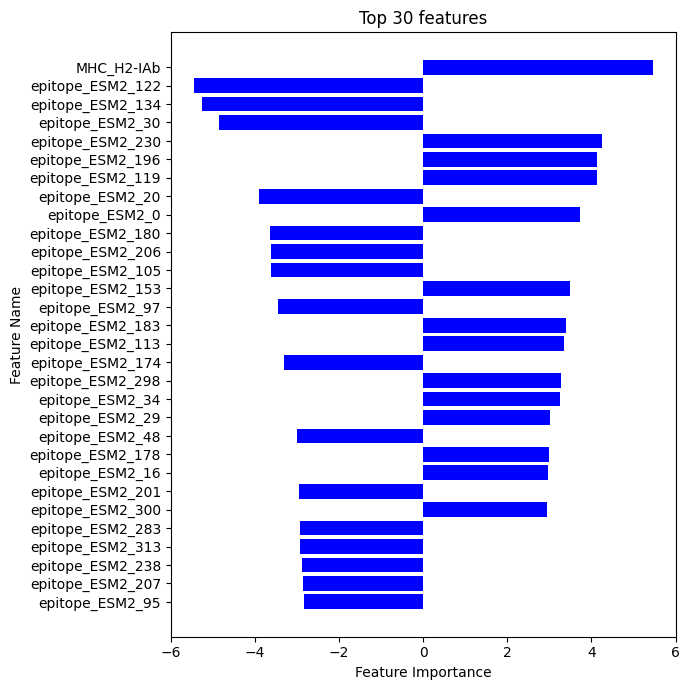

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute, save and plot aggregated feature importance across runs
importance_agg = aggregate_feature_importance(imp=importance_all, f_name=features_name)
# Plot feature importance
importance_agg['abs_importance'] = importance_agg['importance'].abs()
importance_agg_sorted = importance_agg.sort_values(by='abs_importance',ascending=False).drop(columns=['abs_importance'])

top_30 = importance_agg_sorted.head(30)
plt.figure(figsize=(7, 7))
plt.barh(top_30.feature_name, top_30.importance, color='blue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Top 30 features')
plt.gca().invert_yaxis()
plt.tight_layout()
os.makedirs('fig', exist_ok=True)
plt.savefig("fig/importance_"+algorithm+"_"+features_name+"_species_"+species+"_MHC_"+MHC_class+".pdf")

epitope
ALSKGVHFV      0.660651
ALSPVIPHI        0.8125
ALWEIQQVV      0.600823
ALYGFVPVL      0.776042
ALYGSVPVL      0.777778
                 ...   
YADVFHLYL         0.644
YLQPRTFLL      0.727998
YSEHPTFTSQY    0.693006
YVLDHLIVV      0.420049
YVLTWIVGA      0.927778
Name: AUC, Length: 146, dtype: object


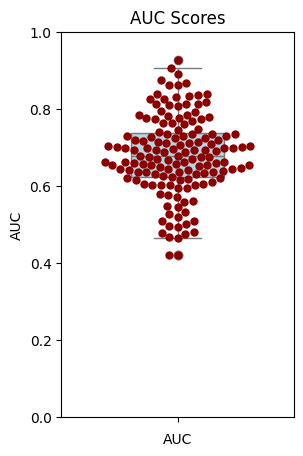

Mean AUC: 0.6801565695747652
Median AUC: 0.6775510204081634


In [ ]:
################################## plot AUC by epitope ##################################

split = "test"
probability = probability_all.loc[probability_all.split==split,:]

auc_values = plot_ROC_curve(probability)

# Save performance
result = pd.DataFrame({'algorithm':[algorithm],'median_auc': [np.median(auc_values)] })
result.to_csv("auc_values_epitope_specific_mean_"+features_name+"_"+algorithm+"_N_TCRs"+str(N_TCRs)+"_"+split+"_species_"+species+"_MHC_"+MHC_class+".csv")
auc_values.to_csv("auc_values_epitope_specific_"+features_name+"_"+algorithm+"_N_TCRs"+str(N_TCRs)+"_"+split+"_species_"+species+"_MHC_"+MHC_class+".csv")

In [ ]:
auc_values

epitope
ALSKGVHFV      0.894267
ALSPVIPHI      0.947073
ALWEIQQVV      0.857731
ALYGFVPVL      0.948094
ALYGSVPVL      0.960166
                 ...   
YADVFHLYL      0.894718
YLQPRTFLL       0.85589
YSEHPTFTSQY    0.881966
YVLDHLIVV      0.905707
YVLTWIVGA      0.971017
Name: AUC, Length: 146, dtype: object


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 13.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 13.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


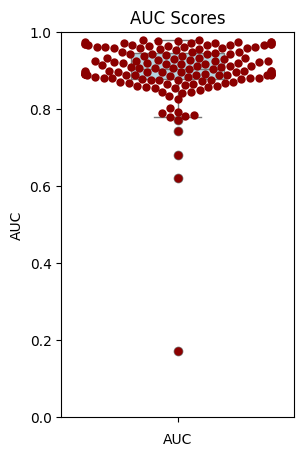

Mean AUC: 0.8972219889822348
Median AUC: 0.9033385873353983


In [ ]:
################################## plot AUC by epitope ##################################

split = "train"
probability = probability_all.loc[probability_all.split==split,:]

auc_values = plot_ROC_curve(probability)

# Save performance
result = pd.DataFrame({'algorithm':[algorithm],'median_auc': [np.median(auc_values)] })
result.to_csv("auc_values_epitope_specific_mean_"+features_name+"_"+algorithm+"_N_TCRs"+str(N_TCRs)+"_"+split+"_species_"+species+"_MHC_"+MHC_class+".csv")
auc_values.to_csv("auc_values_epitope_specific_"+features_name+"_"+algorithm+"_N_TCRs"+str(N_TCRs)+"_"+split+"_species_"+species+"_MHC_"+MHC_class+".csv")
